<a href="https://colab.research.google.com/github/jinkim22/Camelyon17Challenge/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. These will be uploaded for you the week of Oct 24th, at which point we'll update this notebook with a link. 

**Update:** This Google Drive [folder](https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no?usp=sharing) contains many additional slides and masks you can use. Note that while the starter code below downloads one slide from a Google Cloud URL (we have hosted this online for you for convenience), you will need to find a way to work with the other slides yourself for practice. You do not need to use them all! Just a few. You can either host the slides you'll use on Cloud storage using any provider, or you can download from Google Drive in your notebook (this may be slow).

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, on any topic of interest to you.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocessing

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image as im
from skimage.color import rgb2gray
import matplotlib.image as mpimg
import pickle
import random
import shutil
import time
import tensorflow as tf
from keras.preprocessing import image as image_utils
from tensorflow.keras import datasets, layers, models
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
data_augmentation_horiz = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(299, 299, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),])

data_augmentation_vert = tf.keras.Sequential([
    layers.RandomFlip("vertical", input_shape=(299, 299, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

data_augmentation.training=True

In [ ]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

# tissue_pixels = find_tissue_pixels(slide_image)
# percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100

In [ ]:
def preprocess(slide_num, outer_level, inner_level, outer_window, center_window, step, augmentation=False):
  slide_path = 'drive/MyDrive/slides/tumor_' + slide_num + '.tif'
  slide = open_slide(slide_path)
  tumor_mask_path = 'drive/MyDrive/slides/tumor_' + slide_num + '_mask.tif'
  tumor_mask = open_slide(tumor_mask_path)

  tumor = 0
  no_tumor = 0
  outer_factor = slide.level_downsamples[outer_level]
  inner_factor = slide.level_downsamples[inner_level]
  x_offset = (outer_window[0] - center_window[0]) // 2
  y_offset = (outer_window[1] - center_window[1]) // 2
  df_entry = []
  # padding to center 299x299 for the inner level. center pad unit is in inner level
  center_pad = (outer_window[0] * outer_factor - outer_window[0] * inner_factor) / 2

  if not os.path.exists('drive/MyDrive/data_train_img'): 
    os.mkdir('drive/MyDrive/data_train_img')
  if not os.path.exists('drive/MyDrive/data_train_img/none'):
    os.mkdir('drive/MyDrive/data_train_img/none')
  if not os.path.exists('drive/MyDrive/data_train_img/tumor'): 
    os.mkdir('drive/MyDrive/data_train_img/tumor')
  if not os.path.exists('drive/MyDrive/data_train_img/tumor/level' + str(outer_level)): 
    os.mkdir('drive/MyDrive/data_train_img/tumor/level' + str(outer_level))
  if not os.path.exists('drive/MyDrive/data_train_img/none/level' + str(outer_level)): 
    os.mkdir('drive/MyDrive/data_train_img/none/level' + str(outer_level))
  if not os.path.exists('drive/MyDrive/data_train_img/tumor/level' + str(inner_level)): 
    os.mkdir('drive/MyDrive/data_train_img/tumor/level' + str(inner_level))
  if not os.path.exists('drive/MyDrive/data_train_img/none/level' + str(inner_level)): 
    os.mkdir('drive/MyDrive/data_train_img/none/level' + str(inner_level))
  
  for x in range(0, slide.level_dimensions[outer_level][0], step):
    print(x)
    for y in range(0, slide.level_dimensions[outer_level][1], step):
      abs_x = x*outer_factor
      abs_y = y*outer_factor
      slide_img = read_slide(slide, int(abs_x), int(abs_y), outer_level, 
                            outer_window[0], outer_window[1])
      mask_img = read_slide(tumor_mask, int((x+x_offset)*outer_factor), 
                            int((y+y_offset)*outer_factor), outer_level, 
                            center_window[0], center_window[1])

      tp = find_tissue_pixels(mask_img, intensity=0.8)
      if len(tp) >= 1:
        lower_xabs = int(x*outer_factor + center_pad) # x coord in level 0 
        lower_yabs = int(y*outer_factor + center_pad) # y coord in level 0
        lower_window_xabs = int(lower_xabs + (outer_window[0]* inner_factor - center_window[0] * inner_factor) / 2)
        lower_window_yabs = int(lower_yabs + (outer_window[0]* inner_factor - center_window[0] * inner_factor) / 2)
        inner_slide_img = read_slide(slide, lower_xabs, lower_yabs, inner_level, outer_window[0], outer_window[1])
        inner_mask_img = read_slide(tumor_mask, lower_window_xabs, lower_window_yabs, inner_level, 
                                    center_window[0], center_window[1])
        inner_tp = find_tissue_pixels(inner_mask_img, intensity=0.8)

        outer_path = ""
        inner_path = ""
        if np.sum(mask_img) == 0:
          outer_path = "drive/MyDrive/data_train_img/none/level" + str(outer_level) + "/" + slide_num + "_" + str(no_tumor)
          inner_path = "drive/MyDrive/data_train_img/none/level" + str(inner_level) + "/" + slide_num + "_" + str(no_tumor)
          im.fromarray(slide_img).save(outer_path, "JPEG")
          im.fromarray(inner_slide_img).save(inner_path, "JPEG")
          no_tumor += 1
          df_entry += [[0, outer_path, inner_path]]
        else:
          outer_path = "drive/MyDrive/data_train_img/tumor/level" + str(outer_level) + "/" + slide_num + "_" + str(tumor)
          inner_path = "drive/MyDrive/data_train_img/tumor/level" + str(inner_level) + "/" + slide_num + "_" + str(tumor)
          im.fromarray(slide_img).save(outer_path, "JPEG")
          im.fromarray(inner_slide_img).save(inner_path, "JPEG")
          tumor += 1
          df_entry += [[1, outer_path, inner_path]]
          if augmentation:
            for i in range(9):
              outer_path = "drive/MyDrive/data_train_img/tumor/level" + str(outer_level) + "/" + slide_num + "_" + str(tumor) + "_aug" + str(i)
              inner_path = "drive/MyDrive/data_train_img/tumor/level" + str(inner_level) + "/" + slide_num + "_" + str(tumor) + "_aug" + str(i)
              tf.keras.preprocessing.image.array_to_img(data_augmentation(tf.cast(tf.expand_dims(slide_img, 0), tf.float32), training=True)[0]).save(outer_path, "JPEG")
              tf.keras.preprocessing.image.array_to_img(data_augmentation(tf.cast(tf.expand_dims(inner_slide_img, 0), tf.float32), training=True)[0]).save(inner_path, "JPEG")
              df_entry += [[1, outer_path, inner_path]]
  return pd.DataFrame(df_entry, columns=["label", "image_path1", "image_path2"])

In [ ]:
from os import listdir
from os.path import isfile, join
from matplotlib import image
import pandas as pd
def get_slide_df(slide_num):
  level3path = "./drive/MyDrive/data_train_img/tumor/level3/"
  level3files = [f for f in listdir(level3path) if isfile(join(level3path, f))]
  tumor_path1 = []
  tumor_path2 = []
  for f in level3files:
    if str(slide_num) == f[:3] and f[-4:] != ".npy":
      tumor_path1 += [level3path + f]
      tumor_path2 += ["./drive/MyDrive/data_train_img/tumor/level2/" + f]

  level3path = "./drive/MyDrive/data_train_img/none/level3/"
  level3files = [f for f in listdir(level3path) if isfile(join(level3path, f))]
  none_path1 = []
  none_path2 = []
  for f in level3files:
    if str(slide_num) == f[:3] and f[-4:] != ".npy":
      none_path1 += [level3path + f]
      none_path2 += ["./drive/MyDrive/data_train_img/none/level2/" + f]
  path1 = tumor_path1 + none_path1
  path2 = tumor_path2 + none_path2
  labels = [1 for _ in range(len(tumor_path1))] + [0 for _ in range(len(none_path1))]
  df = pd.DataFrame(columns=["label", "image_path1", "image_path2"])
  df.image_path1 = path1
  df.image_path2 = path2
  df.label = labels
  return df

In [ ]:
def balance_dataset(df):
  tumors = list(df.label).count(1)
  non_tumors = list(df.label).count(0)
  c = min(tumors, non_tumors)
  df1 = df.loc[df['label'] == 1]
  df2 = df.loc[df['label'] == 0]
  print(len(df1))
  print(len(df2))
  return pd.concat([df1, df2.sample(n=c)])

# Preprocessing

In [ ]:
df_091 = preprocess(slide_num='091', outer_level=3, inner_level=2, outer_window=[299,299], center_window=[128,128], step=75, augmentation=True)
df_110 = preprocess(slide_num='110', outer_level=3, inner_level=2, outer_window=[299,299], center_window=[128,128], step=75, augmentation=True)
train_df = pd.concat([df_091, df_110])
train = balance_dataset(train_df)
df_test_val = preprocess(slide_num='094', outer_level=3, inner_level=2, outer_window=[299,299], center_window=[128,128], step=75, augmentation=False)

# df_091 = preprocess(slide_num='091', outer_level=3, inner_level=2, outer_window=[299,299], center_window=[128,128], step=75, augmentation=True)
# df_110 = preprocess(slide_num='110', outer_level=3, inner_level=2, outer_window=[299,299], center_window=[128,128], step=75, augmentation=True)
# train_df = pd.concat([df_091, df_110])
# train = balance_dataset(train_df)

In [ ]:
# if resetting from dead runtime
df_091 = get_slide_df("091")  # had to offset tumor_3 by 1 index to get it right
df_091 = balance_dataset(df_091)
df_094 = get_slide_df("094")
df_094 = balance_dataset(df_094)
df_110 = get_slide_df("110")
df_110 = balance_dataset(df_110)
train_df = pd.concat([df_091, df_110])
train = balance_dataset(train_df)
train = train.sample(frac=0.25)
df_test_val = balance_dataset(df_094)

1473
5502
245
33019
36190
15341
37663
16814
245
245


# Make Test and Validation set without augmentation

In [ ]:
df_test_val = preprocess(slide_num='094', outer_level=3, inner_level=2, outer_window=[299,299], center_window=[128,128], step=75, augmentation=False)

In [ ]:
from sklearn.model_selection import train_test_split
df_test_val = balance_dataset(df_test_val)
test, validation = train_test_split(df_test_val, test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=None)

# Dataset is imbalanced. Do data augmentation on training set for tumor slides

In [ ]:
# Create a feature extraction model.
# You should not need to modify this (though you may, if you'd like
# to use a model other than Inception).
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
activations_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# A method to load an image off disk and preprocess
# it appropriately for the model above.
# You should not need to modify this.
def preprocess_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
# You'll need to extract activations for every image in your train, validation,
# and test set. First, create a set of the absolute paths to all of these images 
# (image_path_set). 
image_path_set = set()

# Your code here
for p in train.image_path1:
  image_path_set.add(p)
for p in test.image_path1:
  image_path_set.add(p)
for p in validation.image_path1:
  image_path_set.add(p)
for p in train.image_path2:
  image_path_set.add(p)
for p in test.image_path2:
  image_path_set.add(p)
for p in validation.image_path2:
  image_path_set.add(p)
# Populate this with the absolute paths to all these images.

print("Images to preprocess ", len(image_path_set))
print("This make take a few minutes")

Images to preprocess  28218
This make take a few minutes


In [ ]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. You should not need to modify this.

# Create a dataset to load each image off disk, and extract activations
image_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
image_dataset = image_dataset.map(
  preprocess_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

count = 0
start_time = time.time()
# Loop over the datset, and save all activations to disk in NumPy format
for img_batch, path_batch in image_dataset:
  if count % 50 == 0:
    print(count, " out of ", len(image_dataset))
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
  batch_features = activations_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    if not os.path.exists(path_of_feature + ".npy"): 
      np.save(path_of_feature, bf.numpy())
    # else:
      # print("--- %s seconds ---" % (time.time() - start_time))
  count += 1

0  out of  882
--- 0.0773468017578125 seconds ---
50  out of  882
--- 11.303510665893555 seconds ---
100  out of  882
--- 8.573451519012451 seconds ---
150  out of  882
--- 31.551212072372437 seconds ---
200  out of  882
--- 153.26370930671692 seconds ---
250  out of  882
--- 156.90778303146362 seconds ---
300  out of  882
--- 155.79982352256775 seconds ---
350  out of  882
--- 155.15226340293884 seconds ---
400  out of  882
--- 149.59829473495483 seconds ---
450  out of  882
--- 154.06789827346802 seconds ---
500  out of  882
--- 150.8438994884491 seconds ---
550  out of  882
--- 152.4023950099945 seconds ---
600  out of  882
--- 153.39316749572754 seconds ---
650  out of  882
--- 151.9856309890747 seconds ---
700  out of  882
--- 152.45440888404846 seconds ---
750  out of  882
--- 153.52422094345093 seconds ---
800  out of  882
--- 151.74088740348816 seconds ---
850  out of  882
--- 153.76603889465332 seconds ---


In [ ]:
   # Your code here. 
# Populate these for your training set.
image_path1_train = list(train.image_path1) # a list of absolute paths to images in your training set
image_path2_train = list(train.image_path2)
label_train = list(train.label) # a list of questions in your training set
image_path1_val = list(validation.image_path1)
image_path2_val = list(validation.image_path2)
label_val = list(validation.label)
image_path1_test = list(test.image_path1)
image_path2_test = list(test.image_path2)
label_test = list(test.label)

In [ ]:
print(len(image_path1_train), len(image_path2_train))

13619 13619


# continuing

In [ ]:
def load_np(label, img_path1, img_path2):
  activations1 = np.load(img_path1.decode('utf-8')+'.npy')
  activations2 = np.load(img_path2.decode('utf-8')+'.npy')
  return activations1, activations2, label, img_path1, img_path2

In [ ]:
# You should not need to modify this.
BATCH_SIZE = 32
BUFFER_SIZE = 500
def create_dataset(label, image_path1, image_path2, augment=False):
  dataset = tf.data.Dataset.from_tensor_slices((label, image_path1, image_path2))
  # Load the cached activations off disk
  # Note: This is not the clearest code in the world (it's on our list to 
  # update on the website from the example I borrowed it from,
  # so it's implemented for you in this assignment)
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.float32, tf.int32, tf.string, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  # dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(1)
  return dataset

In [ ]:
train_ds = create_dataset(label_train, image_path1_train, image_path2_train)
val_ds = create_dataset(label_val, image_path1_val, image_path2_val)
test_ds = create_dataset(label_test, image_path1_test, image_path2_test)

In [ ]:
count = 0
none = 0
reprocess = []
done = []
for p in image_path1_train:
  if os.path.exists(p) and os.path.exists(p + ".npy"):
    count += 1
    done += [p]
  else:
    reprocess += [p]
    none += 1
print(count, none)

13619 0


In [ ]:
with open('done_entries1.txt', 'w') as f:
    for fp in done:
      f.write(fp + "\n")

In [ ]:
# image_dataset = tf.data.Dataset.from_tensor_slices(list(reprocess))
# image_dataset = image_dataset.map(
#   preprocess_img, 
#   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# count = 0
# start_time = time.time()
# # Loop over the datset, and save all activations to disk in NumPy format
# for img_batch, path_batch in image_dataset:
#   if count % 100 == 0:
#     print(count)
#     print("--- %s seconds ---" % (time.time() - start_time))
#     start_time = time.time()
#   batch_features = activations_model(img_batch)
#   for bf, p in zip(batch_features, path_batch):
#     path_of_feature = p.numpy().decode("utf-8")
#     if not os.path.exists(path_of_feature + ".npy"): 
#       np.save(path_of_feature, bf.numpy())
#     # else:
#       # print("--- %s seconds ---" % (time.time() - start_time))
#   count += 1

In [ ]:
my_iterator = iter(train_ds)
s = time.time()
activations1_batch, activations2_batch, label_batch, image_path1_batch, image_path2_batch = next(my_iterator)
print(time.time() - s)
print(activations1_batch.shape, activations2_batch.shape, 
      image_path1_batch.shape, image_path2_batch.shape,
      label_batch,)

2.1997334957122803
(32, 8, 8, 2048) (32, 8, 8, 2048) (32,) (32,) tf.Tensor([0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0], shape=(32,), dtype=int32)


In [ ]:
print(len(train_ds))

426


In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32)>

# Model Training

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.models import Model, Sequential

image_input1 = Input(shape=(8, 8, 2048))
image_input2 = Input(shape=(8, 8, 2048))
new_model = Sequential()
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image1 = new_model(image_input1)
encoded_image2 = new_model(image_input2)
merged = tf.keras.layers.concatenate([encoded_image1, encoded_image2])
dense = Dense(100, activation='tanh')(merged)
output = Dense(1, activation='sigmoid')(dense)
new_model = Model(inputs=[image_input1, image_input2], outputs=output)
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 2048)         0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [ ]:
list(label_batch).count(1)

24

In [ ]:
my_iterator = iter(train_ds)
activations1_batch, activations2_batch, label_batch, image_path1_batch, image_path2_batch = next(my_iterator)

for step in range(100):
  metrics = new_model.train_on_batch(x=[activations1_batch, activations2_batch], y=label_batch)
  print("step = ", step, " loss = ", metrics[0], " accuracy = ", metrics[1])

KeyboardInterrupt: ignored

In [ ]:
# You should not need to modify this, but you will want to 
# carefully inspect the output.
for prediction, label in zip(new_model.predict(x=[activations1_batch, activations2_batch]), label_batch):
  print(prediction, label.numpy())

1/1 [==============================] - 0s 92ms/step
[3.09137e-05] 0
[0.00422501] 0
[0.99973387] 1
[5.4735967e-05] 0
[0.99808216] 1
[2.935291e-05] 0
[0.00062364] 0
[0.99969876] 1
[0.9998191] 1
[5.9721904e-05] 0
[0.99987423] 1
[0.9998406] 1
[2.9853034e-05] 0
[0.9998863] 1
[0.9997347] 1
[0.9997497] 1
[0.99960333] 1
[0.9996387] 1
[0.99878556] 1
[0.9999373] 1
[0.00162383] 0
[0.99992156] 1
[2.3034741e-05] 0
[0.9998853] 1
[2.688438e-05] 0
[0.999539] 1
[0.9994373] 1
[0.9997191] 1
[0.99957365] 1
[0.999833] 1
[0.99792695] 1
[0.00315016] 0


In [ ]:
# If you would like to save checkpoints in drive (optional), you can uncomment
# the code below. Otherwise, this notebook will save checkpoints in Colab,
# which is okay for this assignment.

## Mount Google Drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
drive_root = '/gdrive/My Drive/'

## Save checkpoints to Colab by default
# drive_root = "/content/"
# This code will save checkpoints in drive.
# Alternatively, you can modify it to save
# checkpoints in Colab (these will not persist if your instance is terminated,
# but you can manually download them if you like).
# checkpoint_dir = os.path.join(drive_root, "checkpoints")
# checkpoint_dir = os.path.join(checkpoint_dir, "final")

# Used for formatting
# checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")
# You should not need to modify this code.
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# if latest != None:
#   print("Loading weights from", latest)
#   model.load_weights(latest)
# else:
#   print("Checkpoint not found. Starting from scratch")

In [ ]:
checkpoint_dir = os.path.join("/content/drive/MyDrive/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "final")

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  new_model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/drive/MyDrive/checkpoints/final/cp-00000014.ckpt


In [ ]:
# Utilities to help us record metrics.
# You should not need to modify this code
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [ ]:
# You should not need to modify this.
def evaluate(max_steps=None):
  steps = 0
  for activation1_batch, activation2_batch, label_batch, path1_batch, path2_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = new_model.predict(x=[activation1_batch, activation2_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [ ]:
test.to_csv('test.csv', index=False)

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
validation = pd.read_csv("validation.csv")

In [ ]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 15

# Training loop
for epoch in range(epochs):

  start = time.time()
  count = 0
  start1 = time.time()
  # Train for one epoch
  for activation1_batch, activation2_batch, label_batch, path1_batch, 
      path2_batch in train_ds:
    print(str(count) + " out of " + str(len(train_ds)) + " done in " 
          + str(time.time() - start1)[:5] + " seconds")
    start1 = time.time()
    result = new_model.train_on_batch(x=[activation1_batch, activation2_batch],
                                      y=label_batch)
    print(result)
    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])
    count += 1

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, ' + 
              'Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Save a checkpoint after each epoch
  print("Saving weights")
  new_model.save_weights(os.path.join(checkpoint_dir, f"cp-{epoch:08d}.ckpt"))


Streaming output truncated to the last 5000 lines.
74 out of 426 done in 0.264 seconds
[0.017601253464818, 1.0]
75 out of 426 done in 0.293 seconds
[0.0024974446278065443, 1.0]
76 out of 426 done in 0.312 seconds
[0.003049330785870552, 1.0]
77 out of 426 done in 0.302 seconds
[0.009177601896226406, 1.0]
78 out of 426 done in 0.296 seconds
[0.00022803715546615422, 1.0]
79 out of 426 done in 0.322 seconds
[7.456659659510478e-05, 1.0]
80 out of 426 done in 0.267 seconds
[0.001008500694297254, 1.0]
81 out of 426 done in 0.279 seconds
[0.00012854990200139582, 1.0]
82 out of 426 done in 0.293 seconds
[0.0015839624684304, 1.0]
83 out of 426 done in 0.300 seconds
[0.0007211260381154716, 1.0]
84 out of 426 done in 0.284 seconds
[0.0018710049334913492, 1.0]
85 out of 426 done in 0.312 seconds
[0.025425415486097336, 1.0]
86 out of 426 done in 0.311 seconds
[0.0012343268608674407, 1.0]
87 out of 426 done in 0.307 seconds
[0.007043076679110527, 1.0]
88 out of 426 done in 0.278 seconds
[0.0581957064

In [ ]:
train_loss.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.06573775>

In [ ]:
d = pd.DataFrame(columns=["train_acc", "val_acc", "train_loss", "val_loss"])
d.train_acc = acc
d.val_acc = val_acc
d.train_loss = loss
d.val_loss = val_loss

In [ ]:
d.to_csv('results.csv', index=False)

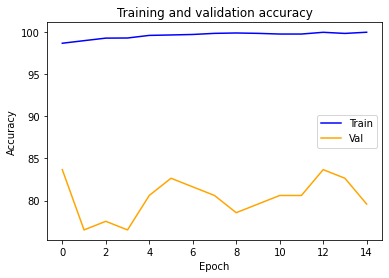

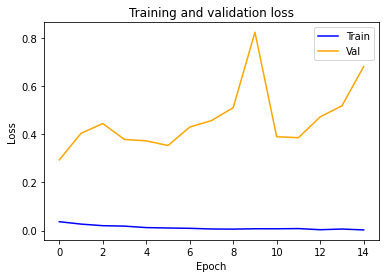

In [ ]:
  # The history object contains results on the training and test
  # sets for each epoch
  # acc = history.history['accuracy']
  # val_acc = history.history['val_accuracy']
  # loss = history.history['loss']
  # val_loss = history.history['val_loss']
  
acc = train_acc_history
val_acc = val_acc_history
loss = train_loss_history
val_loss = val_loss_history

# Get the number of epochs
epochs = range(len(acc))

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Prediction on new slide

In [ ]:
# for activation1_batch, activation2_batch, label_batch, path1_batch, path2_batch in test_ds:
#     if max_steps != None and steps == max_steps:
#       break
my_iterator = iter(test_ds)
s = time.time()
activations1_batch, activations2_batch, label_batch, image_path1_batch, image_path2_batch = next(my_iterator)
predictions = new_model.predict(x=[activation1_batch, activation2_batch])
predictions = np.where(predictions > 0.5, 1, 0)



1/1 [==============================] - 0s 30ms/step


#V3 Preprocess with x y coord

In [ ]:
def preprocess(slide_num, outer_level, inner_level, outer_window, center_window,
               step, augmentation=False):
  slide_path = 'drive/MyDrive/slides/tumor_' + slide_num + '.tif'
  tumor_mask_path = 'drive/MyDrive/slides/tumor_' + slide_num + '_mask.tif'
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  tumor = 0
  no_tumor = 0
  outer_factor = slide.level_downsamples[outer_level]
  inner_factor = slide.level_downsamples[inner_level]
  x_offset = (outer_window[0] - center_window[0]) // 2
  y_offset = (outer_window[1] - center_window[1]) // 2
  df_entry = []
  # padding to center 299x299 for the inner level. center pad unit is in inner level
  center_pad = (outer_window[0] * outer_factor - outer_window[0] * inner_factor) / 2

  if not os.path.exists('drive/MyDrive/data_train_img'): 
    os.mkdir('drive/MyDrive/data_train_img')
  if not os.path.exists('drive/MyDrive/data_train_img/none'):
    os.mkdir('drive/MyDrive/data_train_img/none')
  if not os.path.exists('drive/MyDrive/data_train_img/tumor'): 
    os.mkdir('drive/MyDrive/data_train_img/tumor')
  if not os.path.exists('drive/MyDrive/data_train_img/tumor/level' + str(outer_level)): 
    os.mkdir('drive/MyDrive/data_train_img/tumor/level' + str(outer_level))
  if not os.path.exists('drive/MyDrive/data_train_img/none/level' + str(outer_level)): 
    os.mkdir('drive/MyDrive/data_train_img/none/level' + str(outer_level))
  if not os.path.exists('drive/MyDrive/data_train_img/tumor/level' + str(inner_level)): 
    os.mkdir('drive/MyDrive/data_train_img/tumor/level' + str(inner_level))
  if not os.path.exists('drive/MyDrive/data_train_img/none/level' + str(inner_level)): 
    os.mkdir('drive/MyDrive/data_train_img/none/level' + str(inner_level))
  
  for x in range(0, slide.level_dimensions[outer_level][0], step):
    print(x)
    for y in range(0, slide.level_dimensions[outer_level][1], step):
      abs_x = x*outer_factor
      abs_y = y*outer_factor
      slide_img = read_slide(slide, int(abs_x), int(abs_y), outer_level, 
                            outer_window[0], outer_window[1])
      mask_img = read_slide(tumor_mask, int((x+x_offset)*outer_factor), 
                            int((y+y_offset)*outer_factor), outer_level, 
                            center_window[0], center_window[1])

      tp = find_tissue_pixels(mask_img, intensity=0.8)
      if len(tp) >= 1:
        lower_xabs = int(x*outer_factor + center_pad) # x coord in level 0 
        lower_yabs = int(y*outer_factor + center_pad) # y coord in level 0
        lower_window_xabs = int(lower_xabs + (outer_window[0]* inner_factor - center_window[0] * inner_factor) / 2)
        lower_window_yabs = int(lower_yabs + (outer_window[0]* inner_factor - center_window[0] * inner_factor) / 2)
        inner_slide_img = read_slide(slide, lower_xabs, lower_yabs, inner_level, outer_window[0], outer_window[1])
        inner_mask_img = read_slide(tumor_mask, lower_window_xabs, lower_window_yabs, inner_level, 
                                    center_window[0], center_window[1])
        inner_tp = find_tissue_pixels(inner_mask_img, intensity=0.8)

        outer_path = ""
        inner_path = ""
        if np.sum(mask_img) == 0:
          outer_path = "drive/MyDrive/data_train_img/none/level" + str(outer_level) 
                        + "/" + slide_num + "_" + str(no_tumor)
          inner_path = "drive/MyDrive/data_train_img/none/level" + str(inner_level) 
                        + "/" + slide_num + "_" + str(no_tumor)
          im.fromarray(slide_img).save(outer_path, "JPEG")
          im.fromarray(inner_slide_img).save(inner_path, "JPEG")
          no_tumor += 1
          df_entry += [[0, outer_path, inner_path, abs_x, abs_y]]
        else:
          outer_path = "drive/MyDrive/data_train_img/tumor/level" + str(outer_level) 
                        + "/" + slide_num + "_" + str(tumor)
          inner_path = "drive/MyDrive/data_train_img/tumor/level" + str(inner_level) 
                        + "/" + slide_num + "_" + str(tumor)
          im.fromarray(slide_img).save(outer_path, "JPEG")
          im.fromarray(inner_slide_img).save(inner_path, "JPEG")
          tumor += 1
          df_entry += [[1, outer_path, inner_path, abs_x, abs_y]]
          if augmentation:
            for i in range(9):
              outer_path = "drive/MyDrive/data_train_img/tumor/level" + str(outer_level) 
                            + "/" + slide_num + "_" + str(tumor) + "_aug" + str(i)
              inner_path = "drive/MyDrive/data_train_img/tumor/level" + str(inner_level) 
                            + "/" + slide_num + "_" + str(tumor) + "_aug" + str(i)
              tf.keras.preprocessing.image.array_to_img(data_augmentation(
                  tf.cast(tf.expand_dims(slide_img, 0), tf.float32), training=True)[0]
                  ).save(outer_path, "JPEG")
              tf.keras.preprocessing.image.array_to_img(data_augmentation(
                  tf.cast(tf.expand_dims(inner_slide_img, 0), tf.float32), training=True)[0]
                  ).save(inner_path, "JPEG")
              df_entry += [[1, outer_path, inner_path, abs_x, abs_y]]
  return pd.DataFrame(df_entry, columns=["label", "image_path1", "image_path2", "x_coord", "y_coord"])

In [ ]:
df_075 = preprocess(slide_num='075', outer_level=3, inner_level=2, outer_window=[299,299], center_window=[128,128], step=75, augmentation=True)

In [ ]:
# df_075.to_csv("df_075.csv")
df_075 = pd.read_csv("df_075.csv")

In [ ]:
# You'll need to extract activations for every image in your train, validation,
# and test set. First, create a set of the absolute paths to all of these images 
# (image_path_set). 
separate_slide_df = balance_dataset(df_075)
test_set = set()

# Your code here
for p in separate_slide_df.image_path1:
  test_set.add(p)
for p in separate_slide_df.image_path2:
  test_set.add(p)
# Populate this with the absolute paths to all these images.

print("Images to preprocess ", len(test_set))
print("This make take a few minutes")

3750
19557
Images to preprocess  15000
This make take a few minutes


In [ ]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. You should not need to modify this.

# Create a dataset to load each image off disk, and extract activations
image_dataset = tf.data.Dataset.from_tensor_slices(list(test_set))
image_dataset = image_dataset.map(
  preprocess_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

count = 0
start_time = time.time()
# Loop over the datset, and save all activations to disk in NumPy format
for img_batch, path_batch in image_dataset:
  if count % 50 == 0:
    print(count, " out of ", len(image_dataset))
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
  batch_features = activations_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    if not os.path.exists(path_of_feature + ".npy"): 
      np.save(path_of_feature, bf.numpy())
    # else:
      # print("--- %s seconds ---" % (time.time() - start_time))
  count += 1

0  out of  469
--- 0.4012126922607422 seconds ---
50  out of  469
--- 22.941275596618652 seconds ---
100  out of  469
--- 14.105645895004272 seconds ---
150  out of  469
--- 14.247793197631836 seconds ---
200  out of  469
--- 12.774194955825806 seconds ---
250  out of  469
--- 12.82014274597168 seconds ---
300  out of  469
--- 13.495638608932495 seconds ---
350  out of  469
--- 12.847211122512817 seconds ---
400  out of  469
--- 14.981639385223389 seconds ---
450  out of  469
--- 13.072840452194214 seconds ---


In [ ]:
def load_np(label, img_path1, img_path2, x_coord, y_coord):
  activations1 = np.load(img_path1.decode('utf-8')+'.npy')
  activations2 = np.load(img_path2.decode('utf-8')+'.npy')
  return activations1, activations2, label, img_path1, img_path2, x_coord, y_coord

In [ ]:
# You should not need to modify this.
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def create_dataset_test(label, image_path1, image_path2, x_coord, y_coord):
  dataset = tf.data.Dataset.from_tensor_slices((label, image_path1, image_path2, x_coord, y_coord))
  # Load the cached activations off disk
  # Note: This is not the clearest code in the world (it's on our list to 
  # update on the website from the example I borrowed it from,
  # so it's implemented for you in this assignment)
  dataset = dataset.map(lambda x, y, z, a, b: tf.numpy_function(
      load_np, [x, y, z, a, b], [tf.float32, tf.float32, tf.int32, tf.string, tf.string, tf.float32, tf.float32]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  # dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(1)
  return dataset

In [ ]:
image_path1_newtest = list(separate_slide_df.image_path1) # a list of absolute paths to images in your training set
image_path2_newtest = list(separate_slide_df.image_path2)
label_newtest = list(separate_slide_df.label) # a list of questions in your training set
xcoord_newtest = list(separate_slide_df.x_coord)
ycoord_newtest = list(separate_slide_df.y_coord)

In [ ]:
count, none = 0, 0
for p in image_path2_newtest:
  if os.path.exists(p) and os.path.exists(p + ".npy"):
    count += 1
  else:
    none += 1
print(count, none)


In [ ]:
arr = []
count = 0
for activation1_batch, activation2_batch, label_batch, path1_batch, path2_batch, x_coord, y_coord in new_test_ds:
  print(activation1_batch.shape)
  predictions = new_model.predict(x=[activation1_batch, activation2_batch])
  predictions = np.where(predictions > 0.5, 1, 0)
  print(count)
  count += 1
  for i in range(len(predictions)):
    if predictions[i] == 1:
      arr += [[int(x_coord[i]/8), int(y_coord[i]/8)]]
arr

In [ ]:

# def read_slide(slide, x, y, level, width, height, as_float=False):

slide_path = 'drive/MyDrive/slides/tumor_' + '075' + '.tif'
slide = open_slide(slide_path)
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

In [ ]:
def apply_mask(im, mask, color=(255,255,255)):
    masked = np.copy(im)
    for a in mask: masked[a[0]][a[1]] = color
    return masked

tissue_pixels = find_tissue_pixels(slide_image)
tissue_regions = apply_mask(slide_image, arr)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(tissue_regions)